# SoHAPPY analysis tools
Open a data file and get the detection statistics

In [1]:
import gammapy
gammapy.__version__

'0.18.2'

In [2]:
import os, sys
from setup import col_5, col_3, col_n, col_s

import init as init
import numpy as np
from utilities import MyLabel
from utilities import stamp, Log

import matplotlib.pyplot as plt

## Open file (create csv file if not existing)

In [3]:
file = init.create_csv(debug=True)

Full name : ..\..\..\output\pop_vis24_fullmoonveto-100iter-noacc-prod5\data.txt
 >>>  ..\..\..\output\pop_vis24_fullmoonveto-100iter-noacc-prod5\data.csv
..\..\..\output\pop_vis24_fullmoonveto-100iter-noacc-prod5\data.csv  exists


## Get data and sub-population

- grb : all data
- g_ana : analyzable (visible and simulation completed)
- gn0 : seen North only
- gs0 : seen South only
- gb : seen both site
- gn : seen in North and maybe elsewhere
- gs : seen in South ad maybe elsewhare

In [4]:
(grb, gn0, gs0, gn, gs, gb) = init.get_data(file, debug=True)

 DATA READING from  ..\..\..\output\pop_vis24_fullmoonveto-100iter-noacc-prod5\data.csv
Supplementary information is present
 grb.N==1 seen North only
 gbr.S==1 seen South only
 grb.B==1 seen on both

+-------------------------- Flags ---------------------------+
 Flags:
   No visible flag, unvis           =  -999
   Iteration # from error code, 3s and 5s counts :  100 100 100
+----------------------- Statistics -------------------------+
   Not visible   Fully analyzed      Aborted    
      1818            1182              0       

 Raw statistics - max per site = 2000
  - total      :  3000
  - analyzable :  1182
  - North      :  446
  - South      :  449
  - Both sites :  287 -> total =  1182
  - North only :  160
  - South only :  163
+------------------------------------------------------------+


## Sanity checks

#### Min altitude and delays

+======================== Sanity checks =========================+
 Estimated min altitude in  North  : 24.0
 Estimated min altitude in  South  : 24.0


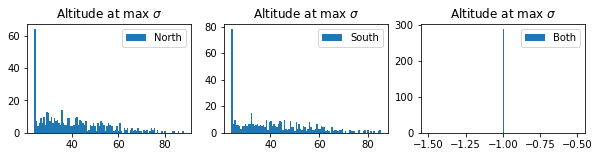

>>> Read configuration from  \\Dapdc5\stolar\My Documents\CTA\Analysis\GRB-Transients-RTA\Posityve_repo\output\pop_vis24_fullmoonveto-100iter-noacc-prod5\config_pop_vis24_fullmoonveto-100iter-noacc-prod5.yaml
 Estimated total delay in  North  : 108.0
 Estimated total delay in  South  : 168.0
+================================================================+


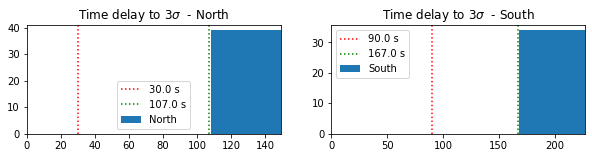

In [5]:
init.sanity_check(file, grb, gn0, gs0, gn, gs, gb, debug=True, old=False) # Use old =True for production before SoHAPPy 0.4

#### Negative significances
The significance is returned by the WStatCountsStatistic function in gammapy, and has a sign which corresponds to the sign of the excess. As a consequence it can be negative.
In case the simulation is done without fluctuation and one trial, the excess can not be negative, and all significance are zero (no excess count) or more.

In [6]:
for g,txt in zip([gn, gs, gn0, gs0, gb],["North", "South", "North only","South only","Both"]):
    n_pos = len(g[g.sigmx>0])
    n0    = len(g[g.sigmx==0])
    n_neg = len(g[g.sigmx<0])
    if n_neg == 0: fluctuate = False
    print(" {:10s} <0: {:<5d} ==0: {:<5d} >0: {:<5d}"
          .format(txt,n_neg,n0,n_pos))

 North      <0: 23    ==0: 16    >0: 407  
 South      <0: 24    ==0: 28    >0: 397  
 North only <0: 8     ==0: 7     >0: 145  
 South only <0: 11    ==0: 15    >0: 137  
 Both       <0: 1     ==0: 1     >0: 285  


# Check statistics

In [7]:
init.rate(grb, nyears=44)


 ------------------------------------------------------------------------------------------------------
 Normalized to 44 years
 ------------------------------------------------------------------------------------------------------
 Rate :               N               S           Nonly           Sonly            Both          Total
 ------  --------------  --------------  --------------  --------------  --------------  --------------
 Vis. :   446.0 +- 21.1   449.0 +- 21.2   161.0 +- 12.7   163.0 +- 12.8   287.0 +- 16.9   611.0 +- 24.7
      :    10.1 +-  0.5    10.2 +-  0.5     3.7 +-  0.3     3.7 +-  0.3     6.5 +-  0.4    13.9 +-  0.6
 ------  --------------  --------------  --------------  --------------  --------------  --------------
 Ana. :   446.0 +- 21.1   449.0 +- 21.2   161.0 +- 12.7   163.0 +- 12.8   287.0 +- 16.9   611.0 +- 24.7
      :    10.1 +-  0.5    10.2 +-  0.5     3.7 +-  0.3     3.7 +-  0.3     6.5 +-  0.4    13.9 +-  0.6
 ------  --------------  -------------- 

# Performance

 Detection level =  0.9  niter =  100  -> Eff. det. level is  90.0


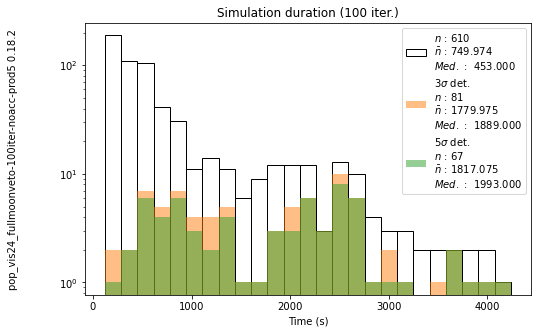

In [8]:
eff_lvl = init.get_eff_lvl(grb)
import pandas as pd
fullpop = pd.concat([gn0, gs0, gb],axis=0)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
init.computing_time(fullpop, eff_lvl) 
stamp(file,axis=fig,where="left")

## Detection levels

In [9]:
pop = fullpop

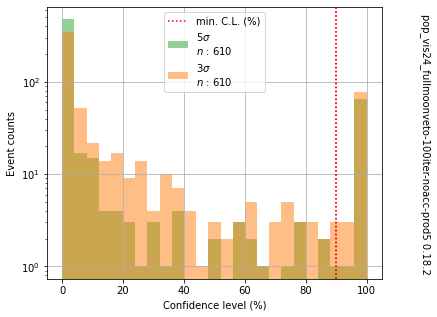

In [10]:
var = pop.d5s
tag = "$5\sigma$"
color = col_5
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
init.detection_level(var/max(pop.err),cl=eff_lvl/max(pop.err),
                     ax=ax, color=color, alpha=0.5, 
                     label=MyLabel(100*var/max(pop.err),label=tag,stat=None))
var = pop.d3s
tag = "$3\sigma$"
color = col_3
init.detection_level(var/max(pop.err),cl=eff_lvl/max(pop.err),
                     ax=ax, color=color, alpha=0.5, 
                     label=MyLabel(100*var/max(pop.err),label=tag,stat=None))
stamp(file,axis=fig)
from utilities import single_legend
single_legend(ax)

In [11]:
def plot_nslices(pop, color="black",ax=None):
    
    # Slice number distribution
    from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
    bins = np.linspace(0,30,31)

    if ax==None: fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
    n, bins, _ = ax.hist(pop.nt, bins=bins,facecolor="none",edgecolor=color,label=MyLabel(pop.nt))
    ax.legend()
    ax.set_xlabel("Number of slices in the GRB")
    ax.xaxis.set_major_locator(MultipleLocator(2.000))       

    return ax

<AxesSubplot:xlabel='Number of slices in the GRB'>

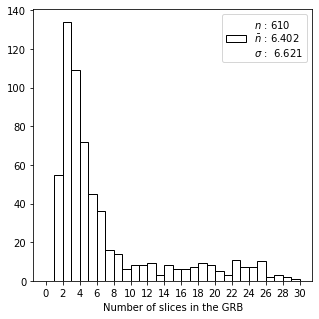

In [12]:
plot_nslices(pop)

In [13]:
def trust_cl(pop,tag,col="black",sigma=3, ax=None):
    
    print(" Sub population ",tag)
    print(" Err code < 0          = ",len(pop[pop.err<0]))
    
    nMC   = sum(pop.err)
    nSL   = sum(pop.nt)
    
    if sigma == 3:
        nok = sum(pop.d3s)
        var = pop.d3s
        tag = "$3\sigma$"
        print(" d3s code < 0          = ",len(pop[pop.d3s<0]))
        
    elif sigma == 5:
        nok = sum(pop.d5s)
        var = pop.d5s
        tag = "$5\sigma$"
        print(" d5s code < 0          = ",len(pop[pop.d5s<0]))       
    
    print(" nMC : Total number of GRB simulation trials = {:10d}".format(nMC))
    print(" nSL : Total number of slices                = {:10d} (mean = {:3.2f})".format(nSL, np.mean(pop.nt)))
    print(" Total number of MC trials (nMC x nSL)       = {:10d}".format(nMC*nSL))
    
    # Since the detection is at 3/5 sigma, 
    # it is expected that as a mean, the background fluctuate at 3/5 sigma in a fraction of the time
    from scipy.stats import norm
    p_value = 1-norm.cdf(sigma)
    nexpect = nMC*nSL*p_value
    print()
    print(" Probability to get a signal (p_value for {:2d} sigma   = {:7.6f}%)".format(sigma,p_value*100))
    print("    => {:2d} sigma occurence in a no signal scenario = {:10.2f}".format(sigma,nexpect))
    print(" Observed {:2d} sigma trials in the data               = {:10.2f}".format(sigma,nok))
    

In [14]:
trust_cl(fullpop,"All",sigma=3,col=col_n)

 Sub population  All
 Err code < 0          =  0
 d3s code < 0          =  0
 nMC : Total number of GRB simulation trials =      61000
 nSL : Total number of slices                =       3905 (mean = 6.40)
 Total number of MC trials (nMC x nSL)       =  238205000

 Probability to get a signal (p_value for  3 sigma   = 0.134990%)
    =>  3 sigma occurence in a no signal scenario =  321552.46
 Observed  3 sigma trials in the data               =   12942.00
